# Ultimate Data Science Challenge Part 3

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

In [1]:
#import packages 
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import sklearn.cluster
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Data Wrangling 

In [2]:
df = pd.read_json('ultimate_data_challenge.json')
df.to_csv('utlimate_data_challenge.csv', index= False)

- **city**: city this user signed up in
- **phone**: primary device for this user
- **signup_date**: date of account registration; in the form ‘YYYY MM DD’
- **last_trip_date**: the last time this user completed a trip; in the form ‘YYYY MM DD’
- **avg_dist**: the average distance in miles per trip taken in the first 30 days after signup
- **avg_rating_by_driver**: the rider’s average rating over all of their trips
- **avg_rating_of_driver**: the rider’s average rating of their drivers over all of their trips
- **surge_pct**: the percent of trips taken with surge multiplier > 1
- **avg_surge**: The average surge multiplier over all of this user’s trips
- **trips_in_first_30_days**: the number of trips this user took in the first 30 days after signing up
- **ultimate_black_user**: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- **weekday_pct**: the percent of the user’s trips occurring during a weekday

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
df.shape

(50000, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
#find missing data
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns = ['count', '%']
missing.sort_values(by='count')

,count,%
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000
weekday_pct,0,0.000
avg_dist,0,0.000
avg_rating_by_driver,201,0.402


In [7]:
#drop missing data 
df=df.dropna()
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  bool   
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB
None
(41445, 12)


In [8]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,2.609675,4.601720,1.073822,8.898709,61.254897,5.460046,4.776446
std,4.059336,0.616104,0.198747,18.322061,34.813848,5.145174,0.404606
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.780000,5.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


## EDA
### City

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'City')

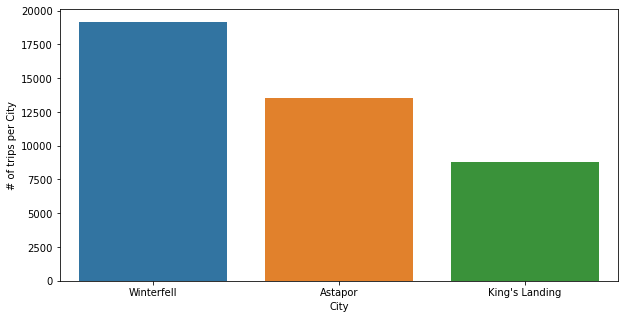

In [9]:
city_count = df['city'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(city_count.index, city_count.values)
plt.ylabel('# of trips per City')
plt.xlabel('City')

### Drivers and Trip

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'city')

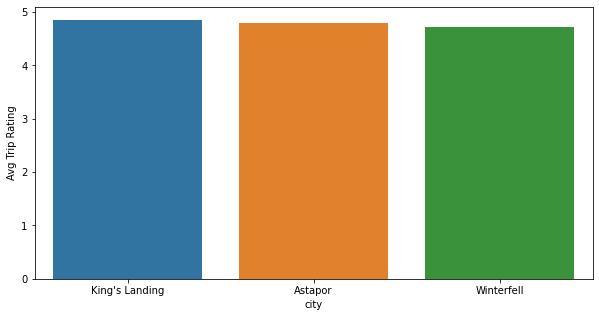

In [10]:
avg_trip_rating_per_city = df.groupby('city')['avg_rating_by_driver'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(avg_trip_rating_per_city.index, avg_trip_rating_per_city.values)
plt.ylabel('Avg Trip Rating')
plt.xlabel('city')

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


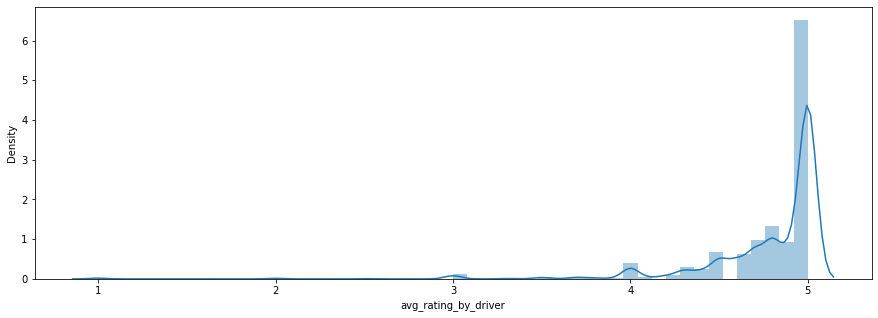

In [11]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df['avg_rating_by_driver'], ax=ax)
plt.show()

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


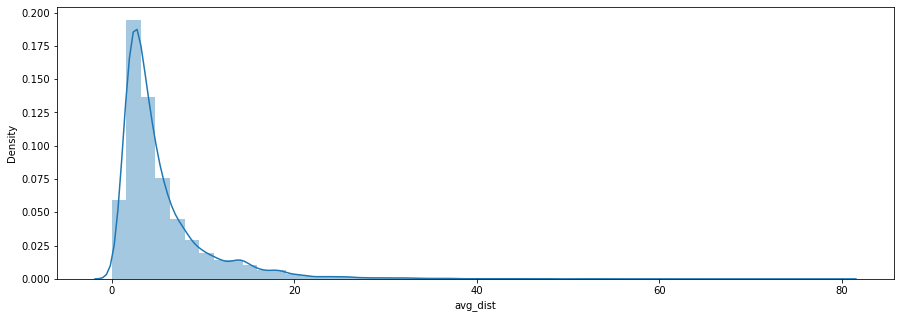

In [12]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df['avg_dist'], ax=ax)
plt.show()

### Customers

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


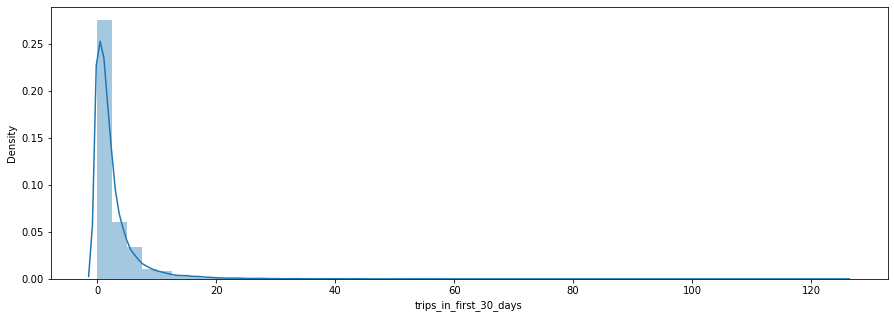

In [13]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df['trips_in_first_30_days'], ax=ax)
plt.show()

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


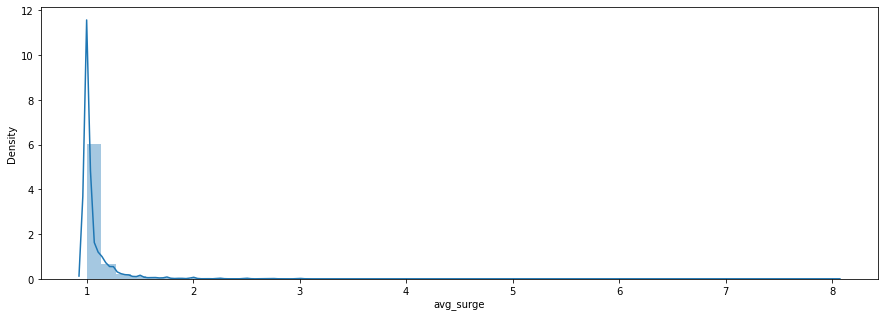

In [14]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df['avg_surge'], ax=ax)
plt.show()

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


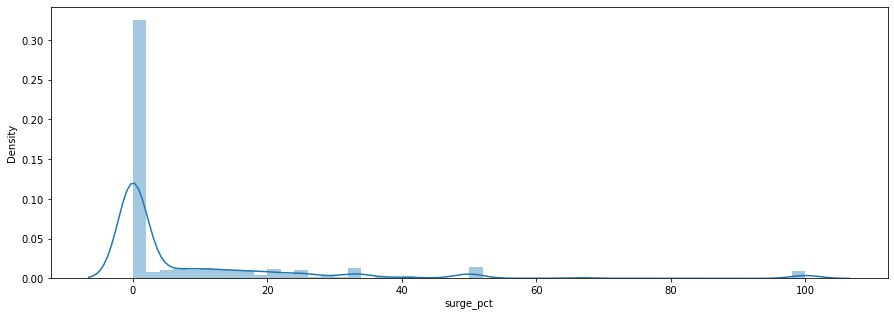

In [15]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df['surge_pct'], ax=ax)
plt.show()

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


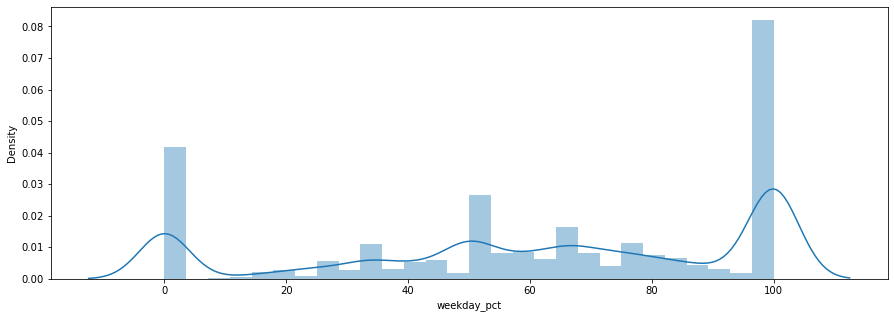

In [16]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df['weekday_pct'], ax=ax)
plt.show()

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Type of Phone')

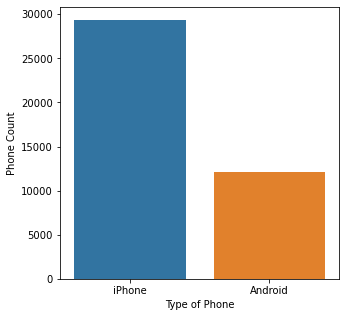

In [17]:
phone_count = df.phone.value_counts().sort_values(ascending=False)
plt.figure(figsize=(5, 5))
sns.barplot(phone_count.index, phone_count.values)
plt.ylabel('Phone Count')
plt.xlabel('Type of Phone')

C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Ultimate Black User')

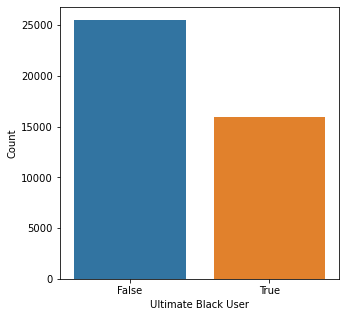

In [18]:
ultimate_black_user_count = df.ultimate_black_user.value_counts().sort_values(ascending=False)
plt.figure(figsize=(5, 5))
sns.barplot(ultimate_black_user_count.index, ultimate_black_user_count.values)
plt.ylabel('Count')
plt.xlabel('Ultimate Black User')

In [19]:
pairplot_data = df.drop(columns=['ultimate_black_user'])
pairplot_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,82.4,3.13,4.9


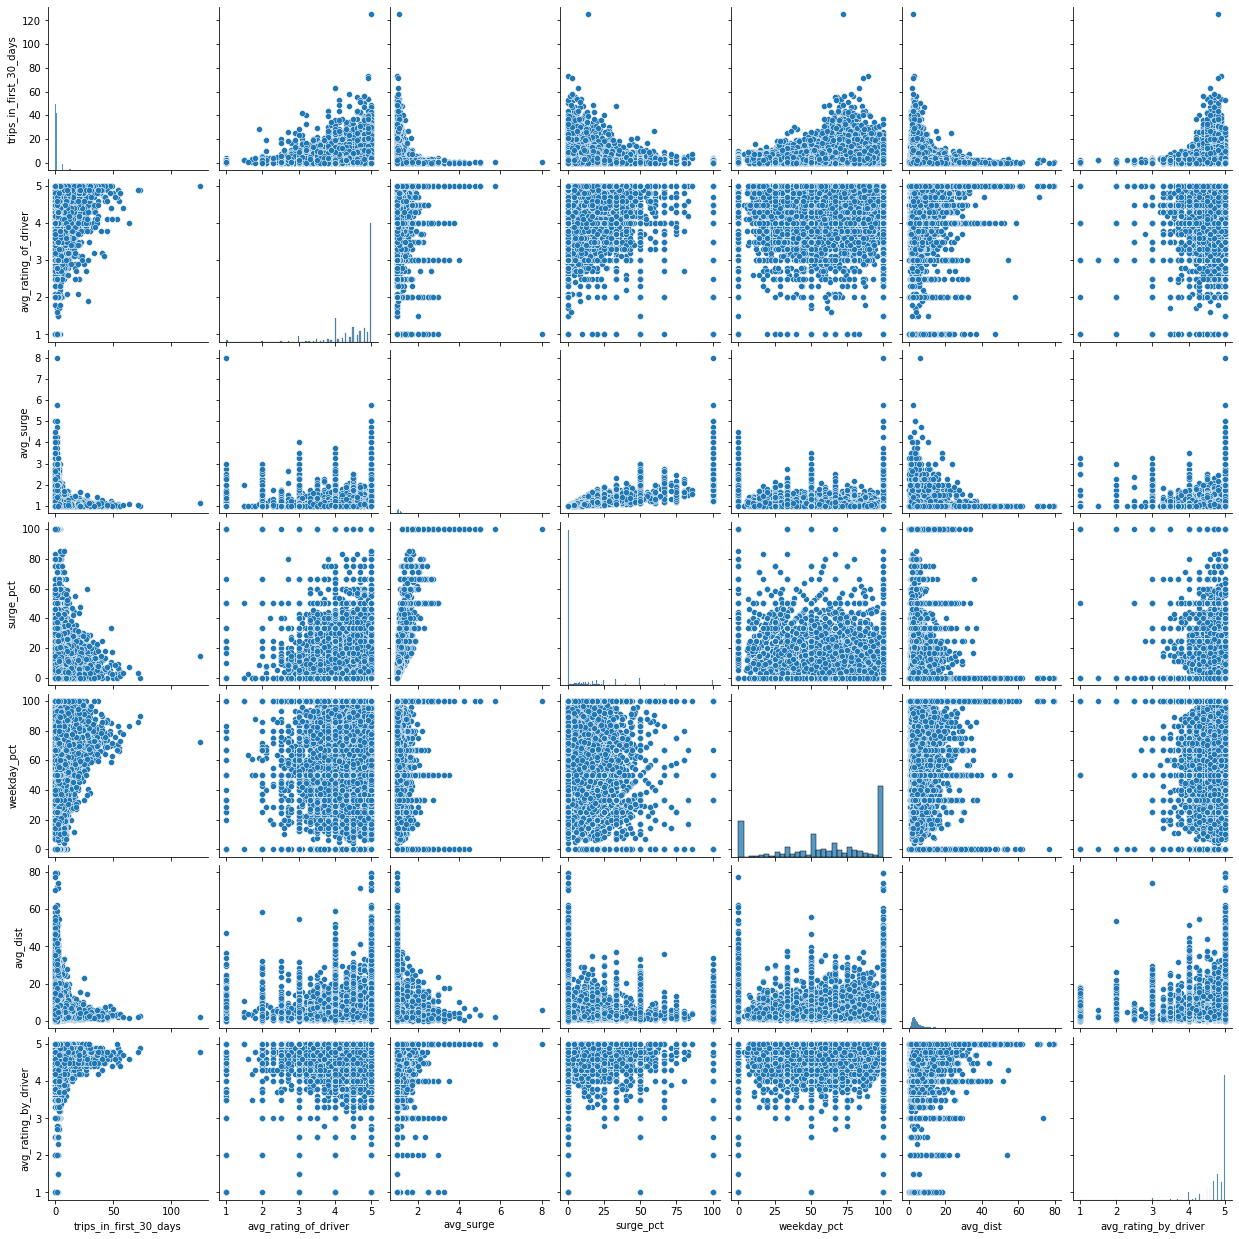

In [20]:
sns.pairplot(pairplot_data)

<AxesSubplot:>

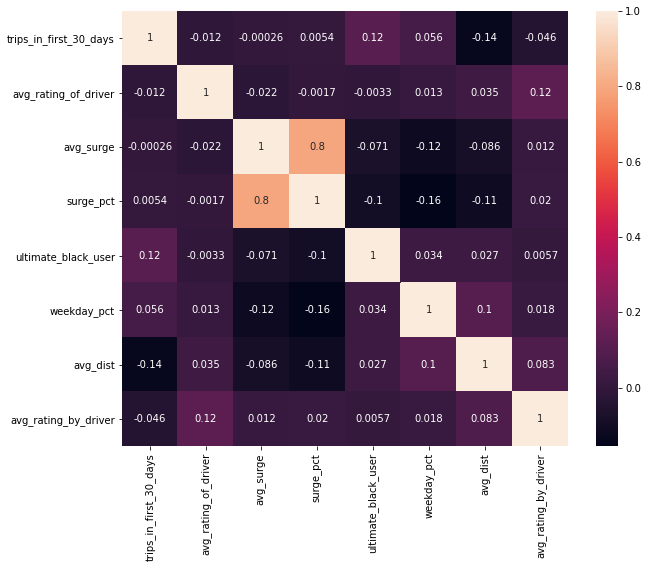

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, ax=ax)

## Pre-Processing
### Identifying users with 6 month retentions

In [22]:
from datetime import timedelta
from datetime import datetime, date
from dateutil.relativedelta import *
from sklearn.preprocessing import StandardScaler

In [23]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  bool   
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


In [25]:
df['signup_date']= pd.to_datetime(df['signup_date'])
df['last_trip_date'] =pd.to_datetime(df['last_trip_date'])

In [26]:
df['retention_date'] = df['signup_date'].apply(lambda x:x + relativedelta(months=+5)) 

In [27]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention_date
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-25
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-06-29
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-06-06
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-10
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-06-27


In [28]:
def retention_check(df):
    if df['last_trip_date'] > df['retention_date']: 
        return 1
    else:
        return 0

In [29]:
df['retention_check'] = df.apply(retention_check, axis=1)

In [30]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention_date,retention_check
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-25,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-06-29,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-06-06,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-10,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-06-27,0


C:\Users\Myngoc\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Retention Users')

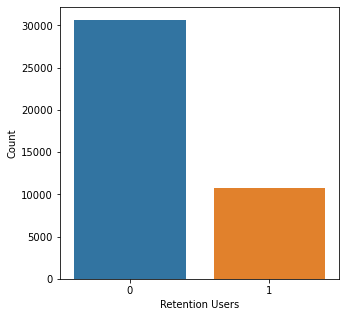

In [31]:
retention_count = df.retention_check.value_counts().sort_values(ascending=False)
plt.figure(figsize=(5, 5))
sns.barplot(retention_count.index, retention_count.values)
plt.ylabel('Count')
plt.xlabel('Retention Users')

In [32]:
retention_count = df.retention_check.value_counts()
retention_count

0    30640
1    10805
Name: retention_check, dtype: int64

In [33]:
retained_percent = len(df[df['retention_check'] == 1]) / len(df) * 100
retained_percent

26.07069610326939

In [34]:
test_data = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [35]:
test_data

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retention_date,retention_check,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,2014-06-25,0,1,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,2014-06-29,0,0,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,2014-06-06,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,2014-06-10,1,1,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,2014-06-27,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,3,2014-01-03,4.8,1.11,2014-07-01,11.1,55.6,2.53,4.7,2014-06-03,1,0,0,1,1
49994,1,2014-01-03,4.6,1.44,2014-05-31,37.5,25.0,2.25,4.5,2014-06-03,0,0,0,1,0
49995,0,2014-01-25,5.0,1.00,2014-06-05,0.0,100.0,5.63,4.2,2014-06-25,0,1,0,1,0
49997,0,2014-01-31,5.0,1.00,2014-05-22,0.0,100.0,3.86,5.0,2014-06-30,0,0,1,0,1


In [36]:
test_data = test_data.drop(columns=['signup_date', 'last_trip_date', 'retention_date', 'retention_check'])

In [37]:
test_data

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,0,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,0,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
49993,3,4.8,1.11,11.1,55.6,2.53,4.7,0,0,1,1
49994,1,4.6,1.44,37.5,25.0,2.25,4.5,0,0,1,0
49995,0,5.0,1.00,0.0,100.0,5.63,4.2,1,0,1,0
49997,0,5.0,1.00,0.0,100.0,3.86,5.0,0,1,0,1


In [38]:
scaler = StandardScaler()
scaled = scaler.fit_transform(test_data)
scaled = pd.DataFrame(scaled)

In [39]:
scaled.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.342505,0.159520,0.131718,0.354838,-0.432445,-0.347912,0.552529,1.929528,-0.927283,0.641872,1.266291
1,-0.642890,0.646456,-0.371440,-0.485689,-0.323292,0.544197,0.552529,-0.518262,-0.927283,-1.557944,-0.789708
2,0.096156,-0.489729,-0.371440,-0.485689,1.112936,-0.911554,0.552529,-0.518262,-0.927283,0.641872,-0.789708
3,1.574248,-0.002792,0.332981,0.605905,0.538445,-0.602523,0.305372,1.929528,-0.927283,0.641872,1.266291
4,2.805992,-0.327417,0.584560,0.158351,0.607384,-0.452866,0.305372,-0.518262,1.078419,-1.557944,-0.789708


## Modeling
### Train-Test Split

In [40]:
X = test_data
y = df['retention_check']

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Decision Tree

In [42]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
print('Train Score:', dt.score(x_train, y_train))
print('Test Score:', dt.score(x_test, y_test))

Train Score: 0.9983110145976596
Test Score: 0.7073229581372904


In [43]:
y_pred_dt = dt.predict(x_test)

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print(conf_matrix_dt)

[[4881 1217]
 [1209  982]]


In [44]:
cv_scores_train_dt = cross_val_score(dt, x_train, y_train, cv=3)
cv_scores_test_dt = cross_val_score(dt, x_test, y_test, cv=3)
print(cv_scores_test_dt)

avg_cv_scores_dt_train = cv_scores_train_dt.mean()
avg_cv_scores_dt_test = cv_scores_test_dt.mean()
cv_scores_std_dt = cv_scores_test_dt.std()
classification_report_dt = classification_report(y_test, y_pred_dt)

print('Avg cross validation train score: ', avg_cv_scores_dt_train)
print('Avg cross validation test score: ', avg_cv_scores_dt_test)
print('Standard deviation in cv scores: ', cv_scores_std_dt)
print('Classification Report:' '\n', classification_report_dt)

[0.6927253  0.70032573 0.69779225]
Avg cross validation train score:  0.7017432742188442
Avg cross validation test score:  0.696947762094342
Standard deviation in cv scores:  0.003159802353410255
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      6098
           1       0.45      0.45      0.45      2191

    accuracy                           0.71      8289
   macro avg       0.62      0.62      0.62      8289
weighted avg       0.71      0.71      0.71      8289



In [45]:
dt = DecisionTreeClassifier()
paramters = {"max_features": [3, 4, 5], "max_depth":[2,4,6,8,10]}
dt_cv = GridSearchCV(dt, paramters, cv=5)
dt_cv.fit(x_train, y_train)
dt_cv.best_params_

{'max_depth': 8, 'max_features': 5}

In [46]:
dt = DecisionTreeClassifier(max_features=5, max_depth=8)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)
print("train score:", dt.score(x_train, y_train))
print("test score:", dt.score(x_test, y_test))
print("average validation score:", (cross_validate(dt, x_train, y_train, cv=5)["test_score"]).mean())
print(classification_report(y_test, y_pred_dt))
print((accuracy_score(y_test, y_pred_dt)*100))

train score: 0.7849559657377247
test score: 0.7724695379418507
average validation score: 0.7726203584836292
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6098
           1       0.60      0.43      0.50      2191

    accuracy                           0.77      8289
   macro avg       0.71      0.66      0.68      8289
weighted avg       0.76      0.77      0.76      8289

77.24695379418507


### Random Forest

In [47]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
print('Train Score:', rf.score(x_train, y_train))
print('Test Score:', rf.score(x_test, y_test))

Train Score: 0.9982506936904331
Test Score: 0.7575099529496924


In [48]:
y_pred_rf = rf.predict(x_test)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix_rf)

[[5330  768]
 [1242  949]]


In [49]:
cv_scores_train_rf = cross_val_score(rf, x_train, y_train, cv=3)
cv_scores_test_rf = cross_val_score(rf, x_test, y_test, cv=3)
print(cv_scores_test_rf)

avg_cv_scores_rf_train = cv_scores_train_rf.mean()
avg_cv_scores_rf_test = cv_scores_test_rf.mean()
cv_scores_std_rf = cv_scores_test_rf.std()
classification_report_rf = classification_report(y_test, y_pred_rf)

print('Avg cross validation train score: ', avg_cv_scores_rf_train)
print('Avg cross validation test score: ', avg_cv_scores_rf_test)
print('Standard deviation in cv scores: ', cv_scores_std_rf)
print('Classification Report:' '\n', classification_report_rf)

[0.76366269 0.77126312 0.75787188]
Avg cross validation train score:  0.7585052479189288
Avg cross validation test score:  0.7642658945590542
Standard deviation in cv scores:  0.005483565292490538
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      6098
           1       0.55      0.43      0.49      2191

    accuracy                           0.76      8289
   macro avg       0.68      0.65      0.66      8289
weighted avg       0.74      0.76      0.75      8289



In [50]:
rf = RandomForestClassifier()
paramters = {"n_estimators": [100, 200, 300], "max_depth":[2,4,6,8,10]}
rf_cv = GridSearchCV(rf, paramters, cv=5)
rf_cv.fit(x_train, y_train)
rf_cv.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [51]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)
print("train score:", rf.score(x_train, y_train))
print("test score:", rf.score(x_test, y_test))
print("average validation score:", (cross_validate(rf, x_train, y_train, cv=5)["test_score"]).mean())
print(classification_report(y_test, y_pred_rf))
print((accuracy_score(y_test, y_pred_rf)*100))

train score: 0.8120098926287851
test score: 0.7806731813246471
average validation score: 0.7820003150752789
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      6098
           1       0.64      0.39      0.49      2191

    accuracy                           0.78      8289
   macro avg       0.72      0.66      0.67      8289
weighted avg       0.76      0.78      0.76      8289

78.06731813246472


### Gradient Boosting

In [52]:
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
print('Train Score:', gb.score(x_train, y_train))
print('Test Score:', gb.score(x_test, y_test))

Train Score: 0.7887260224393775
Test Score: 0.7834479430570636


In [53]:
y_pred_gb = gb.predict(x_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print(conf_matrix_gb)

[[5593  505]
 [1290  901]]


In [54]:
cv_scores_train_gb = cross_val_score(gb, x_train, y_train, cv=3)
cv_scores_test_gb = cross_val_score(gb, x_test, y_test, cv=3)
print(cv_scores_test_gb)

avg_cv_scores_gb_train = cv_scores_train_gb.mean()
avg_cv_scores_gb_test = cv_scores_test_gb.mean()
cv_scores_std_gb = cv_scores_test_gb.std()
classification_report_gb = classification_report(y_test, y_pred_gb)

print('Avg cross validation train score: ', avg_cv_scores_gb_train)
print('Avg cross validation test score: ', avg_cv_scores_gb_test)
print('Standard deviation in cv scores: ', cv_scores_std_gb)
print('Classification Report:' '\n', classification_report_gb)

[0.77198697 0.7752443  0.78574014]
Avg cross validation train score:  0.7829352153456388
Avg cross validation test score:  0.777657135963325
Standard deviation in cv scores:  0.005868204370619044
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      6098
           1       0.64      0.41      0.50      2191

    accuracy                           0.78      8289
   macro avg       0.73      0.66      0.68      8289
weighted avg       0.77      0.78      0.77      8289



In [55]:
gb = GradientBoostingClassifier()
paramters = {"n_estimators": [100, 200, 300], "max_depth":[2,4,6,8,10]}
gb_cv = GridSearchCV(gb, paramters, cv=3)
gb_cv.fit(x_train, y_train)
gb_cv.best_params_

{'max_depth': 2, 'n_estimators': 300}

In [56]:
gb = GradientBoostingClassifier(n_estimators=300, max_depth=2)
gb.fit(x_train, y_train)
y_pred_gb = gb.predict(x_test)
print("train score:", gb.score(x_train, y_train))
print("test score:", gb.score(x_test, y_test))
print("average validation score:", (cross_validate(gb, x_train, y_train, cv=5)["test_score"]).mean())
print(classification_report(y_test, y_pred_gb))
print((accuracy_score(y_test, y_pred_gb)*100))

train score: 0.7914103028109543
test score: 0.7829653757992521
average validation score: 0.7854988240160855
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      6098
           1       0.64      0.42      0.50      2191

    accuracy                           0.78      8289
   macro avg       0.73      0.67      0.68      8289
weighted avg       0.77      0.78      0.77      8289

78.2965375799252


### Final Model

AUC: 0.8148725240664461


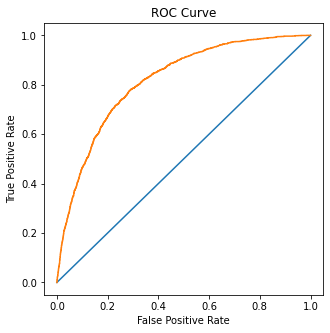

In [57]:
y_pred_prob = gb.predict_proba(x_test)[:,1]
auc_score = roc_auc_score(y_test, y_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(5, 5))
plt.plot([0,1], [0, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

print("AUC:", auc_score)

11


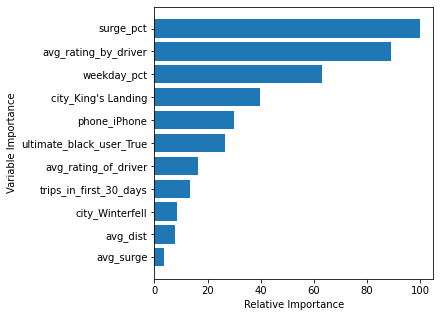

In [58]:
import itertools

feature_importance = gb.feature_importances_
feature_importance = 100 * (feature_importance / feature_importance.max())[:30]
sorted = np.argsort(feature_importance)[:30]

pos = np.arange(sorted.shape[0]) + .5
print(pos.size)
sorted.size
plt.figure(figsize=(5, 5))
plt.barh(pos, feature_importance[sorted], align='center')
plt.yticks(pos, X.columns[sorted])
plt.xlabel('Relative Importance')
plt.ylabel('Variable Importance')
plt.show()

## Conclusion

- 26.07% of customers were retained after 5 months.

- The problem here is to use a classification method since we are trying to predict if customers will be retained after 6 months. 3 Machine learning models were tested; Decision Tree, Random Forest, and Gradient Boosting. These models were tested due to the simplicity and accuracy of the models. These models were compared and the best model was identified. Gradient Boosting had the highest F1 score of 0.77 and accuracy score of 78.3%. The AUC of the Gradient Boosting was 0.815.

### Future Improvements
- Possible event or marketing plan to increase customer surge multiplier.
- Increase customer trip experience as the 2nd highest importance featuer was average rating by driver.
- Increase incentives to use service during the weekdays